**nxm DELAY EFFECT:** this notebook implements a m amplitude qubits by n time qubits delay


Paper reference: Yan, F., Iliyasu, A. M., Guo, Y. & Yang, H. Flexible representation and manipulation of audio signals on quantum computers. Theoretical Computer Science
(2018).

1. Import libraries & Define backend:

In [1]:
# Import libraries
import quantumaudio
from quantumaudio.tools import test_signal
from quantumaudio.tools import plot
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import PermutationGate
from qiskit_aer import AerSimulator
import numpy as np

# Define backend
backend = AerSimulator(method='statevector')


2. Generate signal and encode it:

Encoding scheme:
Quantum State Modulation

Encoded Circuit:


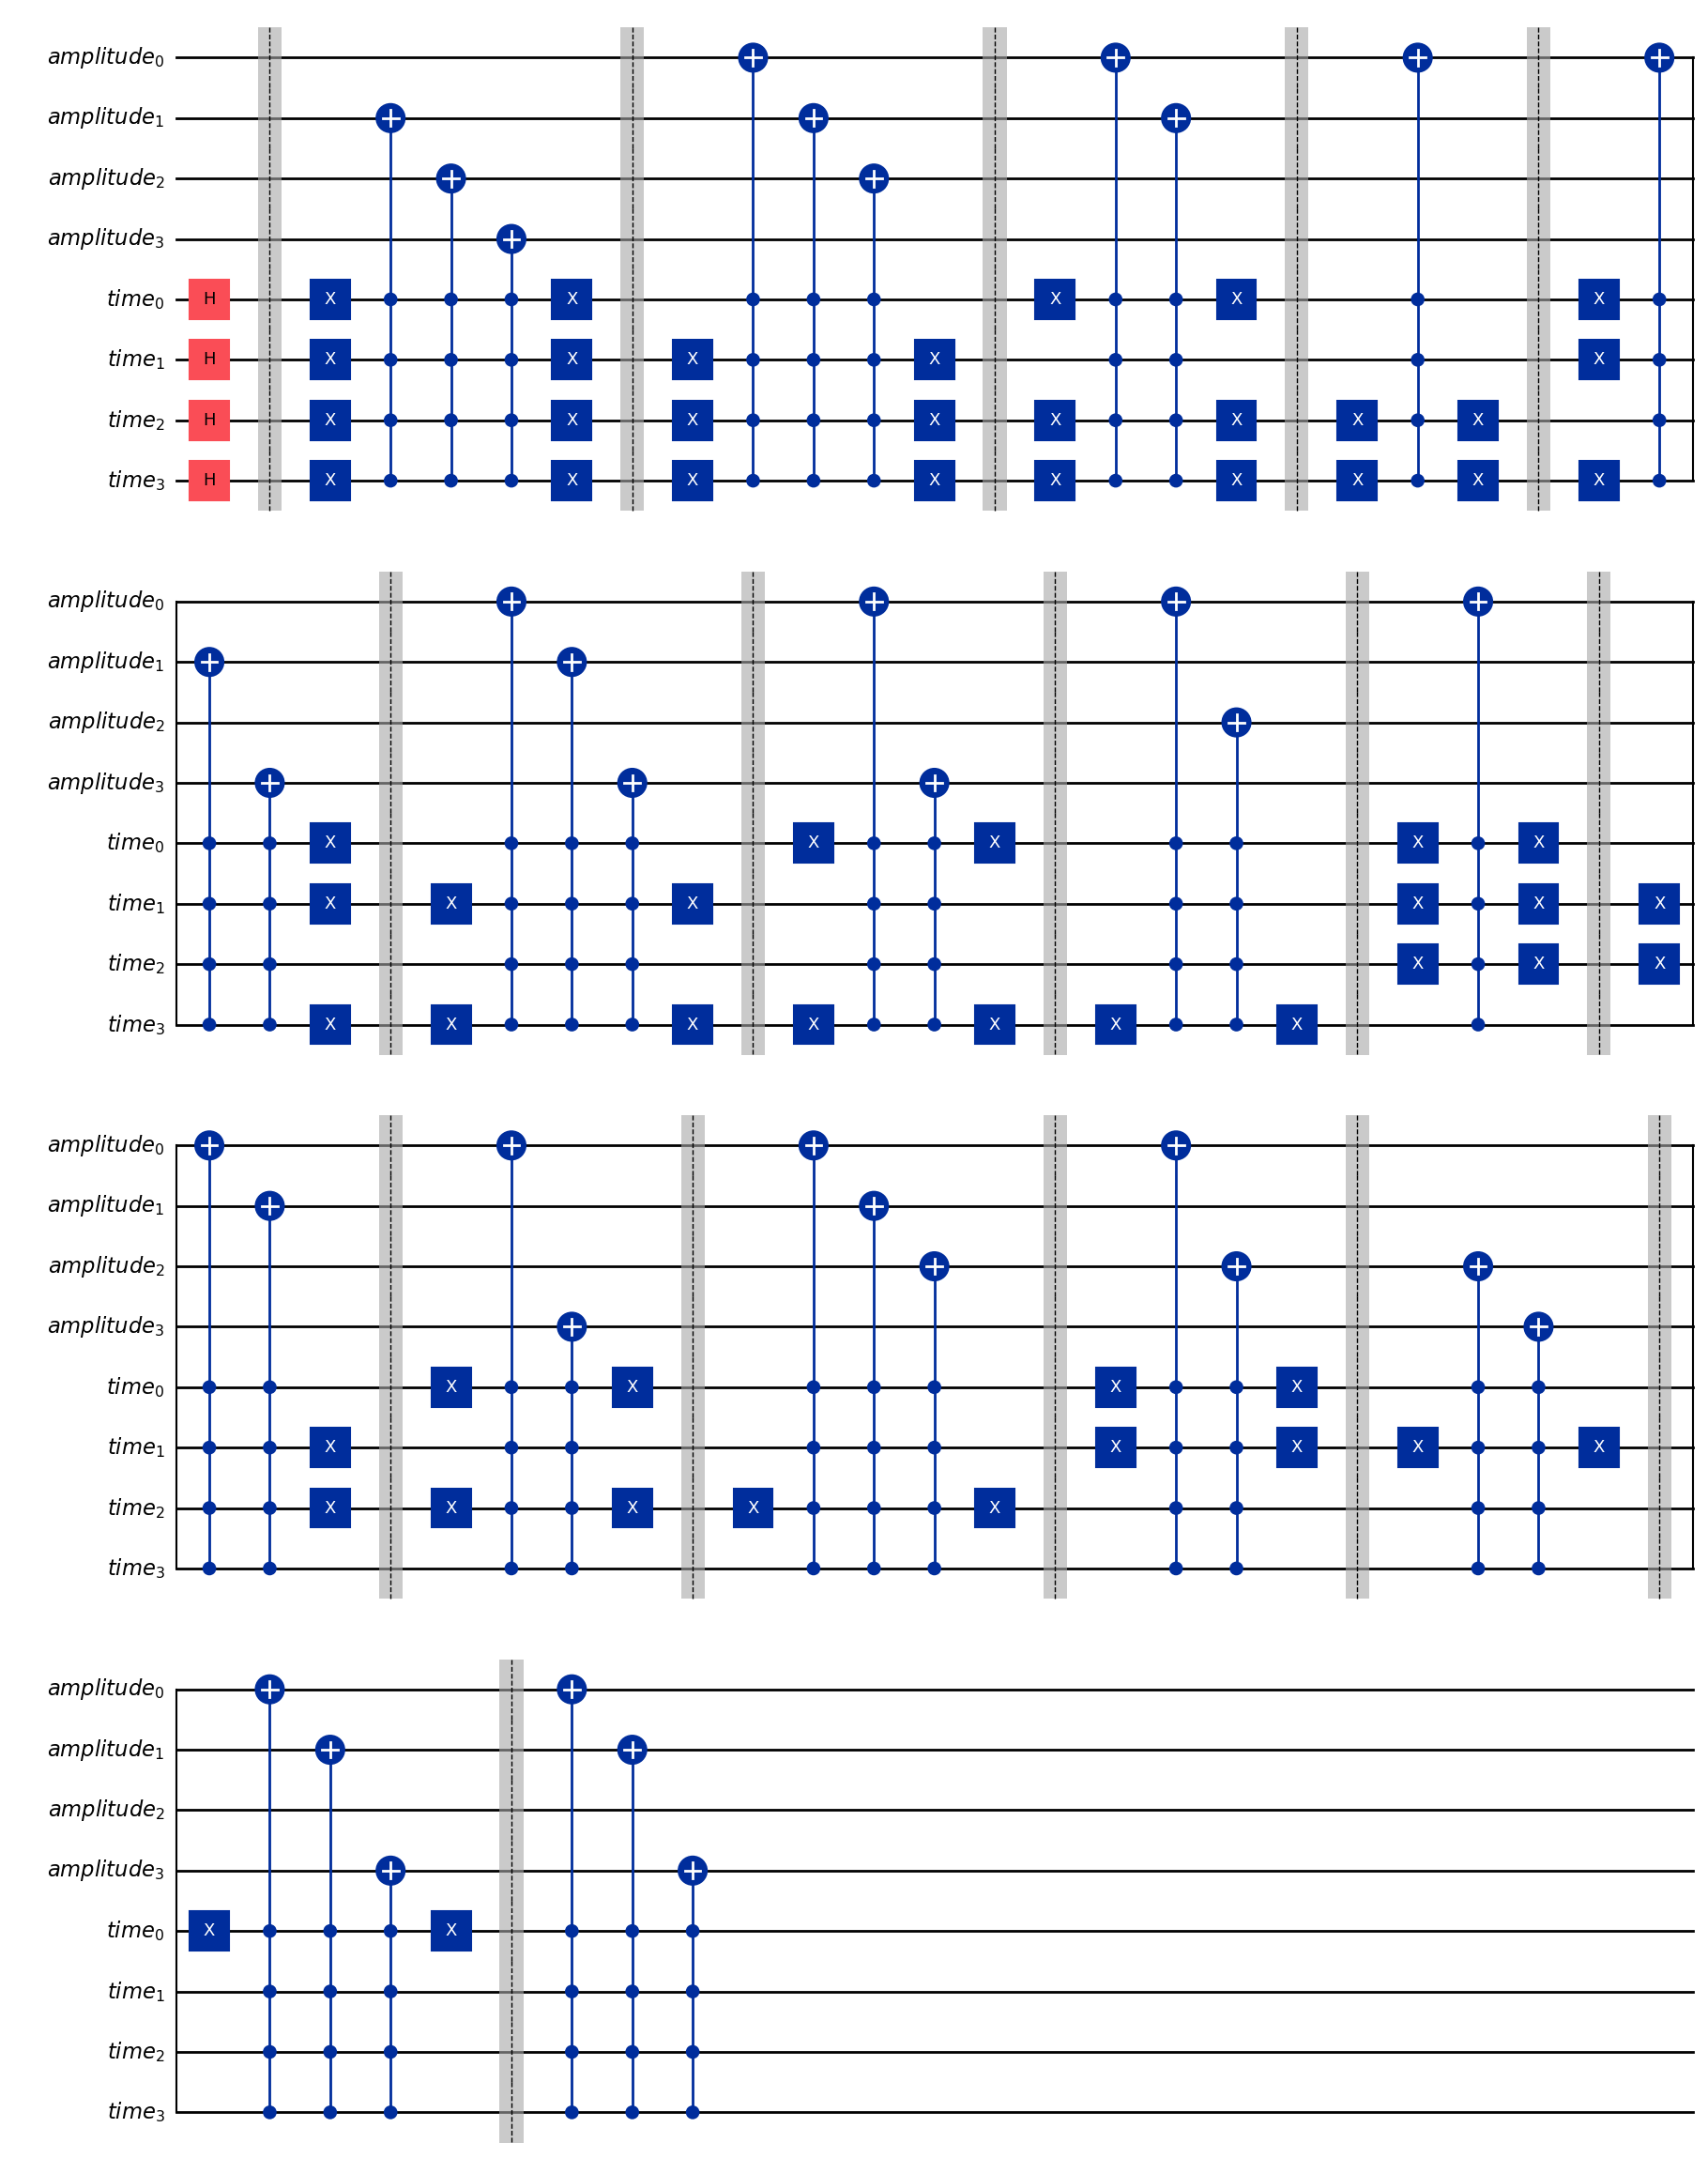

In [2]:
time_qubits = 4  # number of qubits used to represent the time (n)
amp_qubits = 4  # number of qubits used to represent the amplitude (m

# Compute number of samples based on the number of qubits used to represent the time
num_samples = 2**time_qubits

# Import test signal
signal = test_signal(num_channels=1, num_samples=num_samples)
#signal = np.array([0,0.9,0,0,0,0.9,0,0])
print("Encoding scheme:")
scheme = quantumaudio.load_scheme('qsm', qubit_depth=amp_qubits)  # load the QSM scheme
encoded_circuit = scheme.encode(signal, verbose=0, measure=False)
print("\nEncoded Circuit:")
encoded_circuit.draw(output='mpl')

2. Delay effect:

Total qubits: 21

Encoded Circuit with Delay & Measurements:


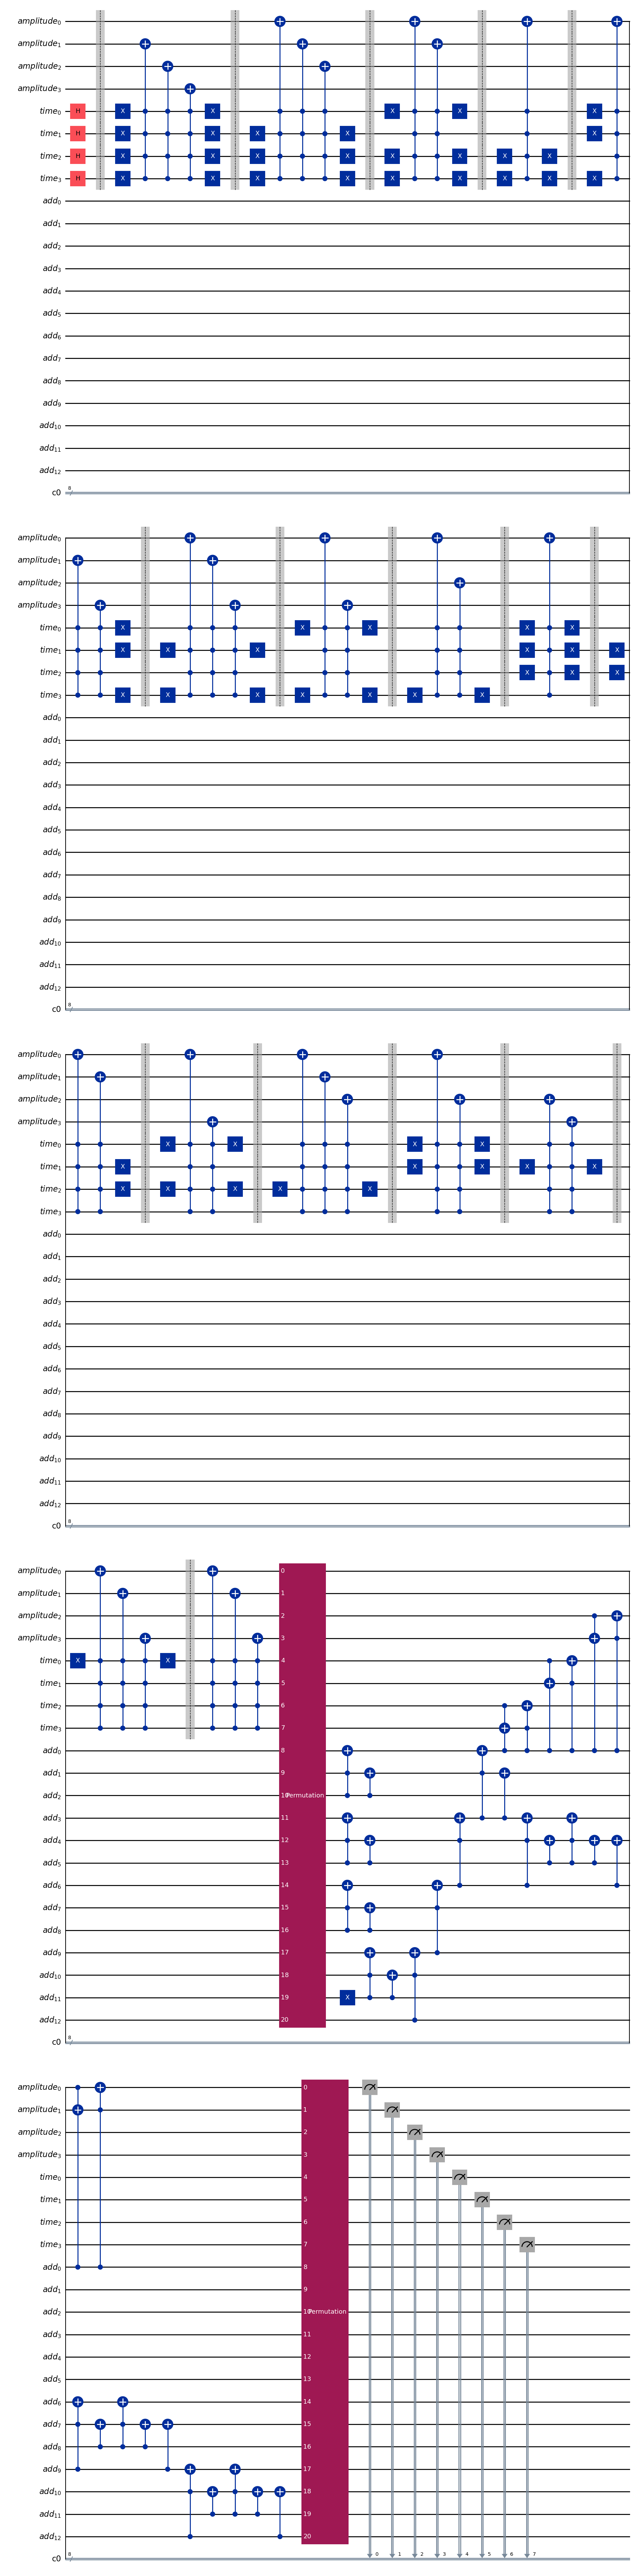

In [3]:
# --- ADD ANCILLAE QUBITS ---
# Compute the number of ancillae qubits needed
ancillae_qubits = amp_qubits + 2*time_qubits + 1 # 2n + m + 1 = 2 per time qubit, m for amplitude qubits, 1 for the carry qubit
# Add the ancillae qubits to the circuit
encoded_circuit.add_register(QuantumRegister(ancillae_qubits, name='add')) # add = additional qubits initialized to 0

# --- PERMUTATION ---
# Compute the total number of qubits
total_qubits = time_qubits + amp_qubits + ancillae_qubits # total number of qubits
print("Total qubits:", total_qubits)

# Define the new order
# Pick the even numbers between 0 and amp_qubits (m)
amp_tags = [2*i for i in range(amp_qubits)]
#print("Amplitude tags:", amp_tags)

# Pick the total_qubits - 3, then total_qubits - 6 and so on until total_qubits - 3*time_qubits (n)
time_tags = [total_qubits - 3*i - 3 for i in range(time_qubits)]
#print("Time tags:", time_tags)

# Pick the remaining qubits (ancillae)
remaining_tags = [i for i in range(total_qubits) if i not in amp_tags and i not in time_tags]
#print("Remaining tags:", remaining_tags)

# Concatenate the lists to get the new order and create the permutation gate
new_order = amp_tags + time_tags + remaining_tags
#print("New order:", new_order)
perm_circuit = PermutationGate(new_order)
encoded_circuit.append(perm_circuit.inverse(), range(total_qubits)) # apply permutation gate

# --- DELAY: TIME ADDER CIRCUIT ---
# Original circuit
delay_circuit = QuantumCircuit(total_qubits)

# TIME INTERVAL SWITCHES
# Apply x gates to the time tags qubits to activate different time intervals
delay_circuit.x(time_tags[0]+1)  # activate the first time interval

# SECTION 1
# Define the sets of qubits (quadruplets) for the operations
# For loop to create the quadruplets of qubits for the first section
quadruplets = []
for a in time_tags:
    quadruplets.append((a+1, a, a-1, a+2))
#print("Quadruplets:", quadruplets)

# Apply the operations in a loop
for ctrl1, ctrl2, target, next_ctrl in quadruplets:
    delay_circuit.ccx(ctrl1, ctrl2, target)
    delay_circuit.cx(ctrl1, ctrl2)
    delay_circuit.ccx(next_ctrl, ctrl2, target)

# SECTION 2
delay_circuit.cx(time_tags[-1]+2, time_tags[-1])

# SECTION 3
# Define the sets of qubits to operate on (excluding the first four)
quadruplets = []
for a in time_tags[-2::-1]:
    quadruplets.append((a+2, a, a-1, a+1))
#print("Quadruplets:", quadruplets)

# Apply the operations in a compact loop
for ctrl1, ctrl2, target, alt_ctrl in quadruplets:
    delay_circuit.ccx(ctrl1, ctrl2, target)
    delay_circuit.cx(alt_ctrl, ctrl2)
    delay_circuit.ccx(alt_ctrl, ctrl2, target)
    delay_circuit.cx(alt_ctrl, ctrl2)
    delay_circuit.cx(ctrl1, ctrl2)   


# --- DELAY: SETTING AMPLITUDES THAT GO TO ZERO ---
# Define the target pairs for the ccx gates
pairs = []
for a in amp_tags[-1::-1]:
    pairs.append((a, a+1))
    pairs.append((a+1, a))
#print("Pairs:", pairs)

# Apply the ccx operations in a loop
for ctrl2, target in pairs:
    delay_circuit.ccx(2*amp_qubits, ctrl2, target)

encoded_circuit = encoded_circuit.compose(delay_circuit)

# --- REVERSE PERMUTATION ---
encoded_circuit.append(perm_circuit, range(total_qubits))

# --- MEASUREMENTS ---
num_measurements = time_qubits + amp_qubits  # we want to measure the first amp and time qubits
if encoded_circuit.num_clbits < num_measurements:
    encoded_circuit.add_register(ClassicalRegister(num_measurements - encoded_circuit.num_clbits))
# Measure only the first n+m qubits
encoded_circuit.measure(range(num_measurements), range(num_measurements)) # ([quantum register], [classical register])

print("\nEncoded Circuit with Delay & Measurements:")
encoded_circuit.draw(output='mpl')

4. Decoded signal and plot comparison:


Original Signal:
[-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
 -0.88383278  0.73235229  0.20223002  0.41614516 -0.95883101  0.9398197
  0.66488528 -0.57532178 -0.63635007 -0.63319098]

Decoded Signal:
[ 0.    -0.25   0.875  0.375  0.125 -0.625 -0.625 -0.875  0.625  0.125
  0.375 -0.875  0.875  0.625 -0.5   -0.625]

Plot:


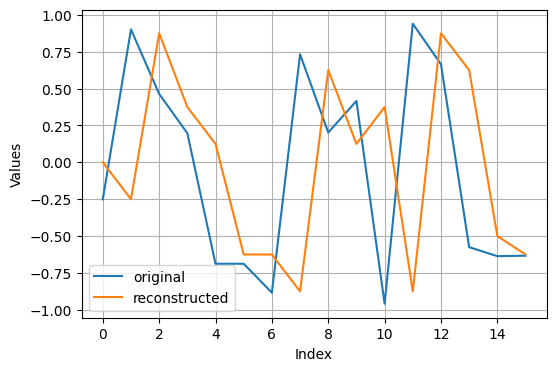

In [4]:
decoded_signal = scheme.decode(encoded_circuit, backend=backend)

print("\nOriginal Signal:") 
print(signal)
print("\nDecoded Signal:")
print(decoded_signal)
print("\nPlot:")
plot([signal, decoded_signal])